# Policy Gradient Methods

In [1]:
import gymnasium as gym
import numpy as np
import time, matplotlib.pyplot as plt
from IPython.display import clear_output, display

In [2]:
SEED = 327
rng = np.random.default_rng(SEED)

## REINFORCE

In [3]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

### Póliza Softmax

El entorno de CartPole-v1 tiene un espacio de acciones discreto:

| Acción | Descripción                       |
|--------|-----------------------------------|
| 0      | Mover el carro a la izquierda     |
| 1      | Mover el carro a la derecha       |

Por lo tanto, se usará `softmax` como **póliza parametrizable**

La función `softmax` parametrizable es:

$$
\pi(a|s, \theta) = \frac{e^{h(s, a, \theta)}}{\sum_{b} e^{h(s, b, \theta)}}
$$

donde:
$$
h(s, a, \theta)
$$ 

es una **preferencia parametrizable** que puede ser lineal:

$$
h(s, a, \theta) = \theta_a^T s
$$

Además, el espacio de estados es continuo, con los siguientes valores:

| Estado        | Descripción                       | Mínimo | Máximo |
|---------------|-----------------------------------|--------|--------|
| Cart Position | Posición del carro                | -4.8   | 4.8    |
| Cart Velocity | Velocidad del carro               | -Inf   | Inf    |
| Pole Angle    | Ángulo del poste                 | -24°   | 24°    |
| Pole Velocity | Velocidad angular del poste       | -Inf   | Inf    |

In [4]:
S = env.observation_space
A = env.action_space

In [5]:
S_len = S.shape[0]
A_len = A.n

In [6]:
class SoftmaxPolicy:
    def __init__(self, W, b):
        self.W = W
        self.b = b

    def logits(self, state):
        return state @ self.W + self.b

    def probs(self, state):
        logits = self.logits(state)
        exp_logits = np.exp(logits - np.max(logits))
        return exp_logits / np.sum(exp_logits)

    def sample(self, state):
        probs = self.probs(state)
        action = rng.choice(A.n, p=probs)
        return action, np.log(probs[action])


### Simulación

In [7]:
W = np.zeros((S_len, A_len))
b = np.zeros(A_len)

In [8]:
policy = SoftmaxPolicy(W, b)

In [9]:
def simulate_episode(policy, render=False):
    states = []
    actions = []
    rewards = []
    log_probs = []

    state, info = env.reset()
    done = False

    while not done:
        if render:
            img = env.render()
            plt.imshow(img)
            plt.axis('off')
            display(plt.gcf())
            clear_output(wait=True)
            time.sleep(0.05)

        action, log_prob = policy.sample(state)
        next_state, reward, terminated, truncated, info = env.step(action)

        states.append(state)
        actions.append(action)
        rewards.append(reward)
        log_probs.append(log_prob)

        state = next_state
        done = terminated or truncated

    return states, actions, rewards, log_probs

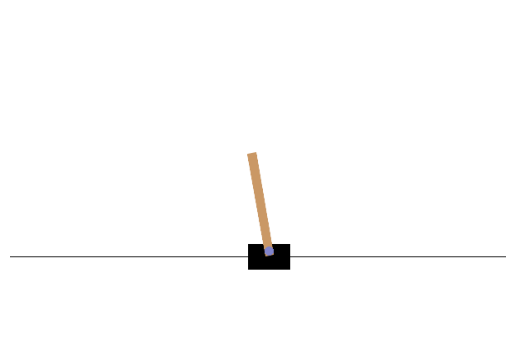

In [10]:
states, actions, rewards, log_probs = simulate_episode(policy, render=True)

### Rendimiento descontado para cada par de estado-acción

Dado que `REINFORCE` se basa en `Monte Carlo`, se usará el rendimiento descontado para cada par de estado-acción como $$G_t$$

$$
G_t = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1}
$$

Además, como se ha visto, en estos casos al ser una estimación sin modelo del entorno, se usará la función valor estado-acción $$Q(s,a)$$ como una estimación del valor esperado del rendimiento descontado:

$$Q(s,a) \approx \mathbb{E}[G_t | S_t=s, A_t=a]$$

In [11]:
def compute_discounted_returns(rewards, gamma=0.99):
    n = len(rewards)
    discounted_returns = np.zeros(n)
    G = 0
    for t in reversed(range(n)):
        G = rewards[t] + gamma * G
        discounted_returns[t] = G

    return discounted_returns

### Actualización de los parámetros de la póliza

Los parámetros de la póliza se actualizan de acuerdo a la siguiente fórmula:

$$\theta \leftarrow \theta + \alpha \gamma^t G_t \left(\frac{\nabla_{\theta} \pi(A_t|S_t, \theta)}{\pi(A_t|S_t, \theta)}\right)$$

donde: 
$$\nabla_{\theta} \pi(A_t|S_t, \theta)$$
es la dirección en el espacio de parámetros que maximiza la probabilidad de seleccionar la acción a en el estado s.

$$G_t$$
escala la magnitud, cuanto mayor sea el rendimiento esperado, mayor será la actualización.

$$\pi(A_t|S_t, \theta)$$
Acciones menos probables generan actualizaciones más grandes.


In [12]:
class LinearValueBaseline:
    def __init__(self):
        self.w = np.zeros(S.shape[0])
        self.b = 0.0

    def predict(self, state) -> float:
        return np.dot(self.w, state) + self.b

    def fit(self, states, targets, lr: float, epochs: int = 1):
        states = np.array(states)
        targets = np.array(targets)

        for _ in range(epochs):
            preds = states @ self.w + self.b
            errors = preds - targets

            grad_w = (2 / len(states)) * (states.T @ errors)
            grad_b = (2 / len(states)) * np.sum(errors)

            self.w -= lr * grad_w
            self.b -= lr * grad_b

In [13]:
baseline = LinearValueBaseline()

In [14]:
def policy_update(states, actions, advantages, policy, lr):    
    grad_W = np.zeros_like(policy.W)
    grad_b = np.zeros_like(policy.b)

    for t in range(len(states)):
        s = states[t]
        a = actions[t]
        p = policy.probs(s)
        
        onehot = np.zeros(policy.b.shape)
        onehot[a] = 1
        
        delta = onehot - p
        
        grad_W += np.outer(s, delta) * advantages[t]
        grad_b += delta * advantages[t]

    policy.W += lr * grad_W
    policy.b += lr * grad_b
    
    new_policy = SoftmaxPolicy(policy.W.copy(), policy.b.copy())
    return new_policy

In [15]:
num_episodes = 500
gamma = 0.99
lr_pi = 5e-3
lr_v  = 1e-2

In [16]:
returns_history = []

In [17]:
for ep in range(num_episodes):
    states, actions, rewards, _ = simulate_episode(policy, render=False)

    returns = compute_discounted_returns(rewards, gamma)
    values  = np.array([baseline.predict(s) for s in states])
    advantages = returns - values
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    policy = policy_update(states, actions, advantages, policy, lr=lr_pi)
    
    baseline.fit(states, returns, lr=lr_v, epochs=1)
    
    ep_return = float(np.sum(rewards))
    returns_history.append(ep_return)

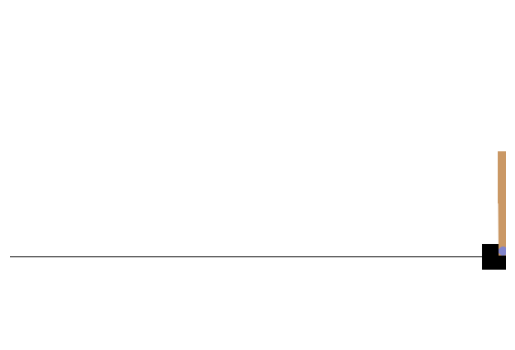

In [18]:
states, actions, rewards, log_probs = simulate_episode(policy, render=True)

### Resultados

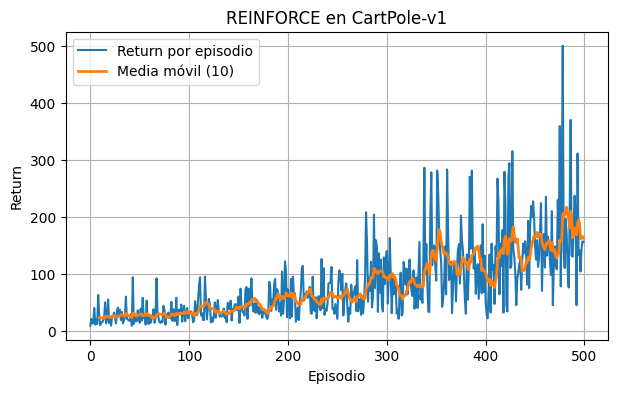

Return promedio (últimos 10): 162.7


In [19]:
plt.figure(figsize=(7,4))
plt.plot(returns_history, label='Return por episodio')
window = 10
if len(returns_history) >= window:
    ma = np.convolve(returns_history, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, window-1+len(ma)), ma, linewidth=2, label=f'Media móvil ({window})')

plt.xlabel('Episodio')
plt.ylabel('Return')
plt.title('REINFORCE en CartPole-v1')
plt.grid(True)
plt.legend()
plt.show()

print(f"Return promedio (últimos 10): {np.mean(returns_history[-10:]):.1f}")

La curva muestra un aprendizaje claro pero ruidoso: el retorno promedio pasa de ~20–40 a ~150–200, con picos altos (incluso cerca del tope de 500) y caídas pronunciadas, lo típico en REINFORCE por tres razones: la política es estocástica, el gradiente se estima con un solo episodio (alta varianza) y CartPole es frágil (un error termina temprano). La baseline lineal y la estandarización de ventajas ya ayudan a estabilizar, pero no eliminan la variabilidad; por eso ves “dientes de sierra” aun con tendencia ascendente. Interpretación: la política sí mejora y ocasionalmente alcanza trayectorias casi óptimas, pero aún no es establemente buena. Para consolidar la subida, conviene (i) acumular minibatches de 5 episodios por actualización, (ii) normalizar estados antes de entrar a la política/valor, (iii) bajar un poco lr de la política (≈1e-3–3e-3) o promediar el gradiente por longitud del episodio, y (iv) añadir un bonus de entropía pequeño para evitar colapso de exploración. En síntesis, se cumplen los objetivos del task y el comportamiento observado es coherente con REINFORCE; con esas mejoras, la media móvil debería subir de forma más suave y sostenida.